# *Project Overview*

**Spark Moive Recommendation :**
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/) and provide personalized movie recommendation for users.

# *Part 1: Data ETL and Data Exploration*

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bi

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!ls

sample_data  spark-3.0.0-bin-hadoop3.2	spark-3.0.0-bin-hadoop3.2.tgz


In [ ]:
spark.version

'3.0.0'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
movies = spark.read.load("drive/My Drive/Movie Recommendation Project/movies.csv", format='csv', header = True)
ratings = spark.read.load("drive/My Drive/Movie Recommendation Project/ratings.csv", format='csv', header = True)
links = spark.read.load("drive/My Drive/Movie Recommendation Project/links.csv", format='csv', header = True)
tags = spark.read.load("drive/My Drive/Movie Recommendation Project/tags.csv", format='csv', header = True)

In [ ]:
movies.show(10)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
ratings.show(10)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
+------+-------+------+---------+
only showing top 10 rows



In [ ]:
links.show(10)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
|      6|0113277|   949|
|      7|0114319| 11860|
|      8|0112302| 45325|
|      9|0114576|  9091|
|     10|0113189|   710|
+-------+-------+------+
only showing top 10 rows



In [ ]:
tags.show(10)

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
+------+-------+-----------------+----------+
only showing top 10 rows



In [ ]:
cnt_rating_user = ratings.groupBy("userID").count().toPandas()['count'].min()
cnt_rating_movie = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('The minimum number of ratings for each user is {}'.format(cnt_rating_user))
print('The minimum number of ratings for each movie is {}'.format(cnt_rating_movie))

The minimum number of ratings for each user is 20
The minimum number of ratings for each movie is 1


In [ ]:
cnt_user = tags.groupBy("userID").count().toPandas()['count'].max()
cnt_movie = tags.groupBy("movieId").count().toPandas()['count'].max()
print('The maxmium number of tags for each user is {}'.format(cnt_user))
print('The maximum number of tags for each movie is {}'.format(cnt_movie))

The maxmium number of tags for each user is 1507
The maximum number of tags for each movie is 181


In [ ]:
ratingsPd = ratings.groupBy("movieId").count().toPandas()
ratingsPd['count'] == 1
ratingsPd['count'] == 0
tmp1 = ratingsPd.loc[ratingsPd['count'] == 1].count()
tmp2 = ratings.select('movieId').distinct().count()
tmp3 = ratingsPd.loc[ratingsPd['count'] == 0].count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))
print('{} out of {} movies are rated by nobody'.format(tmp3, tmp2))

movieId    3446
count      3446
dtype: int64 out of 9724 movies are rated by only one user
movieId    0
count      0
dtype: int64 out of 9724 movies are rated by nobody


# *Part 2: Spark SQL and OLAP*

In [ ]:
movies.registerTempTable("movies")
ratings.registerTempTable("ratings")
links.registerTempTable("links")
tags.registerTempTable("tags")

### Q1: The number of Users

In [ ]:
ratings.select('userId').distinct().count()



610

### Q2: The number of Movies

In [ ]:
movies.select('movieId').distinct().count()

9742

###Q3:  How many movies are rated by users? How many movies are not rated before? List movies not rated before



In [ ]:
q3_answer_1=spark.sql('SELECT COUNT(movieId) AS rated_movies FROM movies WHERE movieId IN (SELECT movieId FROM ratings)')
q3_answer_1.show()

+------------+
|rated_movies|
+------------+
|        9724|
+------------+



In [ ]:
q3_answer_2=spark.sql('SELECT COUNT(movieId) AS non_rated_movies FROM movies WHERE movieId NOT IN (SELECT movieId FROM ratings)')
q3_answer_2.show()

+----------------+
|non_rated_movies|
+----------------+
|              18|
+----------------+



In [ ]:
movies.join(ratings, 'movieId', 'leftanti').select('title').distinct().sort("title").show()


+--------------------+
|               title|
+--------------------+
|Browning Version,...|
|Call Northside 77...|
|  Chalet Girl (2011)|
|  Chosen, The (1981)|
|Color of Paradise...|
|For All Mankind (...|
|I Know Where I'm ...|
|In the Realms of ...|
|Innocents, The (1...|
|Mutiny on the Bou...|
|      Niagara (1953)|
|Parallax View, Th...|
|        Proof (1991)|
|Road Home, The (W...|
|Roaring Twenties,...|
|      Scrooge (1970)|
|This Gun for Hire...|
|Twentieth Century...|
+--------------------+



### Q4: List Movie Genres

In [ ]:
q4_answer=spark.sql('SELECT genres FROM movies')
q4_answer.show()

+--------------------+
|              genres|
+--------------------+
|Adventure|Animati...|
|Adventure|Childre...|
|      Comedy|Romance|
|Comedy|Drama|Romance|
|              Comedy|
|Action|Crime|Thri...|
|      Comedy|Romance|
|  Adventure|Children|
|              Action|
|Action|Adventure|...|
|Comedy|Drama|Romance|
|       Comedy|Horror|
|Adventure|Animati...|
|               Drama|
|Action|Adventure|...|
|         Crime|Drama|
|       Drama|Romance|
|              Comedy|
|              Comedy|
|Action|Comedy|Cri...|
+--------------------+
only showing top 20 rows



In [ ]:
# split genres into several rows
from pyspark.sql.functions import *
movies_genres = movies.withColumn("genres", explode(split("genres", "[|]")))
movies_genres.show()


+-------+--------------------+---------+
|movieId|               title|   genres|
+-------+--------------------+---------+
|      1|    Toy Story (1995)|Adventure|
|      1|    Toy Story (1995)|Animation|
|      1|    Toy Story (1995)| Children|
|      1|    Toy Story (1995)|   Comedy|
|      1|    Toy Story (1995)|  Fantasy|
|      2|      Jumanji (1995)|Adventure|
|      2|      Jumanji (1995)| Children|
|      2|      Jumanji (1995)|  Fantasy|
|      3|Grumpier Old Men ...|   Comedy|
|      3|Grumpier Old Men ...|  Romance|
|      4|Waiting to Exhale...|   Comedy|
|      4|Waiting to Exhale...|    Drama|
|      4|Waiting to Exhale...|  Romance|
|      5|Father of the Bri...|   Comedy|
|      6|         Heat (1995)|   Action|
|      6|         Heat (1995)|    Crime|
|      6|         Heat (1995)| Thriller|
|      7|      Sabrina (1995)|   Comedy|
|      7|      Sabrina (1995)|  Romance|
|      8| Tom and Huck (1995)|Adventure|
+-------+--------------------+---------+
only showing top

In [ ]:
 movies_genres.select('genres').distinct().show()


+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



### Q5: Movie for Each Category

In [ ]:
from pyspark.sql.functions import *

movies_genres = movies.withColumn("genres", explode(split("genres", "[|]")))
movies_genres.show()


+-------+--------------------+---------+
|movieId|               title|   genres|
+-------+--------------------+---------+
|      1|    Toy Story (1995)|Adventure|
|      1|    Toy Story (1995)|Animation|
|      1|    Toy Story (1995)| Children|
|      1|    Toy Story (1995)|   Comedy|
|      1|    Toy Story (1995)|  Fantasy|
|      2|      Jumanji (1995)|Adventure|
|      2|      Jumanji (1995)| Children|
|      2|      Jumanji (1995)|  Fantasy|
|      3|Grumpier Old Men ...|   Comedy|
|      3|Grumpier Old Men ...|  Romance|
|      4|Waiting to Exhale...|   Comedy|
|      4|Waiting to Exhale...|    Drama|
|      4|Waiting to Exhale...|  Romance|
|      5|Father of the Bri...|   Comedy|
|      6|         Heat (1995)|   Action|
|      6|         Heat (1995)|    Crime|
|      6|         Heat (1995)| Thriller|
|      7|      Sabrina (1995)|   Comedy|
|      7|      Sabrina (1995)|  Romance|
|      8| Tom and Huck (1995)|Adventure|
+-------+--------------------+---------+
only showing top

In [ ]:
movies_count = movies_genres.groupby('genres').count()
movies_count.sort('count').show()

+------------------+-----+
|            genres|count|
+------------------+-----+
|(no genres listed)|   34|
|         Film-Noir|   87|
|              IMAX|  158|
|           Western|  167|
|           Musical|  334|
|               War|  382|
|       Documentary|  440|
|           Mystery|  573|
|         Animation|  611|
|          Children|  664|
|           Fantasy|  779|
|            Horror|  978|
|            Sci-Fi|  980|
|             Crime| 1199|
|         Adventure| 1263|
|           Romance| 1596|
|            Action| 1828|
|          Thriller| 1894|
|            Comedy| 3756|
|             Drama| 4361|
+------------------+-----+



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

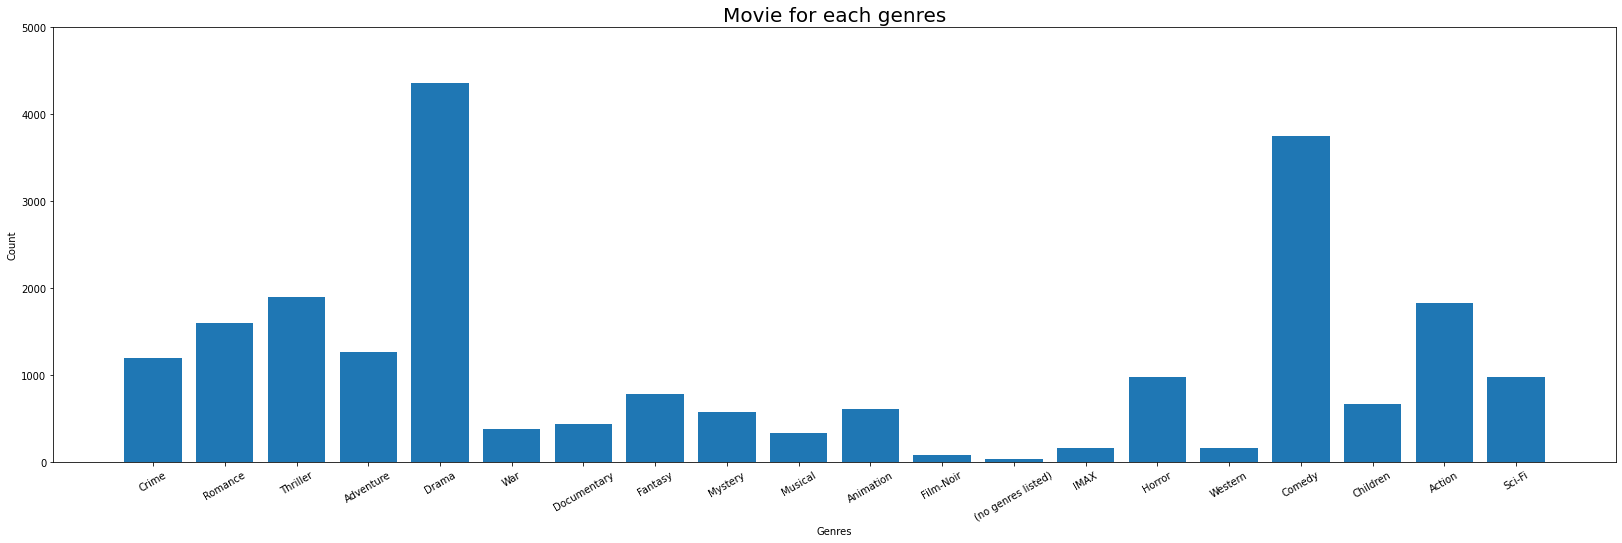

In [ ]:
movies_count = movies_genres.groupby('genres').count().toPandas()

plt.figure(figsize=(28,8)) 
plt.bar(movies_count['genres'],movies_count['count'])
# adjust: xlabel, ylabel,y-axis scale; adjust background color
# add title
plt.title("Movie for each genres",fontsize=20)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.ylim(top=5000)
plt.grid(False)
plt.xticks(rotation = 30)


# *Part 3: Spark ALS based approach for training model*
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples. Cold-Start problem can arise during addition of a new user or a new item where both do not have history in terms of ratings.
[link text](https://www.quora.com/What-are-different-techniques-used-to-address-the-cold-start-problem-in-recommender-systems)
Cold start problems can be handled by recommendations based on meta-information, such as:
For new users, we can use their location, age, gender, browser, and user device to predict recommendations.
For new movies, we can use genre, cast, and crew to recommend it to target users.
[link text](https://towardsdatascience.com/how-to-build-a-movie-recommendation-system-67e321339109)

In [ ]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
movies_ratings=ratings.drop('timestamp')

In [ ]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movies_ratings = movies_ratings.withColumn("userId", movies_ratings["userId"].cast(IntegerType()))
movies_ratings = movies_ratings.withColumn("movieId", movies_ratings["movieId"].cast(IntegerType()))
movies_ratings = movies_ratings.withColumn("rating", movies_ratings["rating"].cast(FloatType()))

In [ ]:
movies_ratings.show()


+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



###ALS Model Selection and Evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.
[link text](https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html)
[link text](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html)

In [ ]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder


In [ ]:
#Create test and train set
(training,test)=movies_ratings.randomSplit([0.8,0.2])

In [ ]:
#Create ALS model
als = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         maxIter=5, 
          rank=10, 
          regParam=0.01, 
         coldStartStrategy="drop"
)

In [ ]:
#Tune model using ParamGridBuilder
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [5,10,15,20,25]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .addGrid(als.maxIter, [3, 5, 10]) \
            .build()

In [ ]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  60


In [ ]:
# Build Cross validation 
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [ ]:
#Fit ALS model to training data
cvModel = cv.fit(training)

In [ ]:
#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

### Model testing
And finally, make a prediction and check the testing error.

In [ ]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
# Check the best model parameters
print("**Best Model**")
# Print "Rank"
print("  Rank:", bestModel._java_obj.parent().getRank())
# Print "MaxIter"
print("  MaxIter:", bestModel._java_obj.parent().getMaxIter())
# Print "RegParam"
print("  RegParam:", bestModel._java_obj.parent().getRegParam())
# Check RMSE
print ("RMSE: "+str(rmse))

**Best Model**
  Rank: 10
  MaxIter: 10
  RegParam: 0.15
RMSE: 0.8636990583433524


In [ ]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   133|    471|   4.0| 2.6783078|
|   436|    471|   3.0|  3.436668|
|   599|    471|   2.5| 2.7049658|
|   182|    471|   4.5| 3.7293477|
|   474|    471|   3.0| 3.1608717|
|   387|    471|   3.0| 3.0473716|
|   136|    471|   4.0| 3.3409865|
|   216|    471|   3.0| 3.1093323|
|   260|    471|   4.5|  3.420598|
|   357|    471|   3.5| 3.9656312|
|    44|    833|   2.0| 2.7460616|
|   307|    833|   1.0|  2.168872|
|   608|    833|   0.5| 2.6118271|
|   554|   1088|   5.0|  3.949739|
|    41|   1088|   1.5|  2.995057|
|    10|   1088|   3.0| 3.5416715|
|   188|   1088|   4.0| 3.6636355|
|    42|   1088|   3.0| 3.4930146|
|   587|   1238|   4.0| 3.6031947|
|   268|   1238|   5.0| 3.5907788|
+------+-------+------+----------+
only showing top 20 rows



### Model apply and see the performance


In [ ]:
data=bestModel.transform(movies_ratings)
rmse = evaluator.evaluate(data)
print ("RMSE = "+str(rmse))
print(data)

RMSE = 0.6679467077305911
DataFrame[userId: int, movieId: int, rating: float, prediction: float]


In [ ]:
data.registerTempTable("alldata")


In [ ]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0|  4.854329|
|   133|    471|   4.0| 2.6783078|
|   597|    471|   2.0|  3.865368|
|   385|    471|   4.0| 3.2864034|
|   436|    471|   3.0|  3.436668|
|   602|    471|   4.0|  3.087093|
|    91|    471|   1.0|  2.701008|
|   409|    471|   3.0| 3.5800462|
|   372|    471|   3.0| 3.0970495|
|   599|    471|   2.5| 2.7049658|
|   603|    471|   4.0| 3.5285196|
|   182|    471|   4.5| 3.7293477|
|   218|    471|   4.0| 3.4358969|
|   474|    471|   3.0| 3.1608717|
|   500|    471|   1.0|  2.134003|
|    57|    471|   3.0| 3.4005132|
|   462|    471|   2.5| 2.6710312|
|   387|    471|   3.0| 3.0473716|
|   610|    471|   4.0| 3.6571984|
|   217|    471|   2.0| 2.5276077|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
all = spark.sql("select * from movies join alldata on movies.movieId=alldata.movieId")
all.show()

+-------+--------------------+------+------+-------+------+----------+
|movieId|               title|genres|userId|movieId|rating|prediction|
+-------+--------------------+------+------+-------+------+----------+
|    148|Awfully Big Adven...| Drama|   191|    148|   5.0|  4.854329|
|    471|Hudsucker Proxy, ...|Comedy|   133|    471|   4.0| 2.6783078|
|    471|Hudsucker Proxy, ...|Comedy|   597|    471|   2.0|  3.865368|
|    471|Hudsucker Proxy, ...|Comedy|   385|    471|   4.0| 3.2864034|
|    471|Hudsucker Proxy, ...|Comedy|   436|    471|   3.0|  3.436668|
|    471|Hudsucker Proxy, ...|Comedy|   602|    471|   4.0|  3.087093|
|    471|Hudsucker Proxy, ...|Comedy|    91|    471|   1.0|  2.701008|
|    471|Hudsucker Proxy, ...|Comedy|   409|    471|   3.0| 3.5800462|
|    471|Hudsucker Proxy, ...|Comedy|   372|    471|   3.0| 3.0970495|
|    471|Hudsucker Proxy, ...|Comedy|   599|    471|   2.5| 2.7049658|
|    471|Hudsucker Proxy, ...|Comedy|   603|    471|   4.0| 3.5285196|
|    4

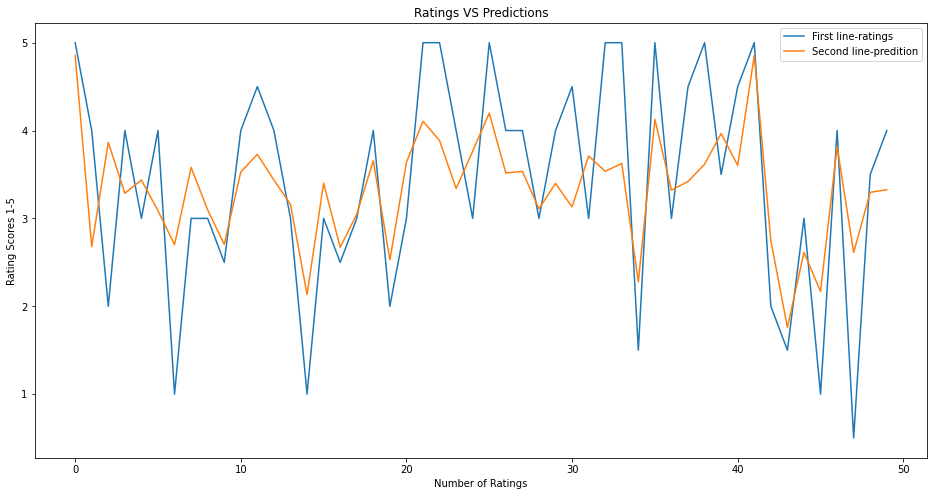

In [ ]:
# Data visualization
from IPython.core.pylabtools import figsize
rating = data.select('rating').toPandas()
predict = data.select('prediction').toPandas()
plt.figure(figsize = [16,8])
plt.plot(rating.head(50))
plt.plot(predict.head(50))
plt.title('Ratings VS Predictions')
plt.xlabel('Number of Ratings')
plt.ylabel('Rating Scores 1-5')
plt.legend(['First line-ratings', 'Second line-predition'])


# *Part 4: Spark ALS Model Apllication*


## *Recommend moive to users with id: 280, 87.* 
For our collaborative filtering method, we’ll use a matrix factorization technique.

In [ ]:
# Generate top 10 movie recommendations for each user
userRecs = bestModel.recommendForAllUsers(10)
userRecs.limit(10).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[3379, 4.832397]...|
|   463|[[3379, 4.933619]...|
|   496|[[3379, 4.5744567...|
|   148|[[3379, 4.5930386...|
|   540|[[3379, 5.2583075...|
|   392|[[25771, 4.953919...|
|   243|[[3379, 5.344067]...|
|    31|[[3379, 5.075283]...|
|   516|[[4429, 4.7395263...|
|   580|[[3379, 4.764318]...|
+------+--------------------+



In [ ]:
userRecs = userRecs\
    .withColumn("rec", explode("recommendations"))\
    .select('userId', col("rec.movieId"), col("rec.rating"))

userRecs.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   471|   3379| 4.832397|
|   471|   7767|4.5246334|
|   471|   6201| 4.522017|
|   471|   4495| 4.522017|
|   471|   8235| 4.522017|
|   471|   7842| 4.494816|
|   471|   3451|4.4794016|
|   471|  84273| 4.460722|
|   471| 179135| 4.460722|
|   471| 117531| 4.460722|
+------+-------+---------+



In [ ]:
print("Recommended movies for user with id '280' are as follows.")

userRecs.join(movies, on='movieId').filter('userId = 280').show()


Recommended movies for user with id '280' are as follows.
+-------+------+---------+--------------------+--------------+
|movieId|userId|   rating|               title|        genres|
+-------+------+---------+--------------------+--------------+
|  51931|   280|5.3771195|Reign Over Me (2007)|         Drama|
|   3379|   280| 4.930354| On the Beach (1959)|         Drama|
|   1046|   280|4.8946905|Beautiful Thing (...| Drama|Romance|
|  77846|   280| 4.866971| 12 Angry Men (1997)|   Crime|Drama|
|  25906|   280| 4.866971|Mr. Skeffington (...| Drama|Romance|
|  93008|   280| 4.866971|Very Potter Seque...|Comedy|Musical|
|  26073|   280| 4.850056|Human Condition I...|     Drama|War|
|   4256|   280| 4.850056|Center of the Wor...|         Drama|
| 184245|   280| 4.850056|De platte jungle ...|   Documentary|
| 179135|   280| 4.850056|Blue Planet II (2...|   Documentary|
+-------+------+---------+--------------------+--------------+



In [ ]:
print("Recommended movies for user with id '87' are as follows.")

userRecs.join(movies, on='movieId').filter('userId = 87').show()
# This is spark dataframe

Recommended movies for user with id '87' are as follows.
+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|   3379|    87| 5.339153| On the Beach (1959)|               Drama|
|   7842|    87|5.2851486|         Dune (2000)|Drama|Fantasy|Sci-Fi|
|  51931|    87|5.1431723|Reign Over Me (2007)|               Drama|
|  25771|    87| 5.074493|Andalusian Dog, A...|             Fantasy|
|   5490|    87|5.0080824|  The Big Bus (1976)|       Action|Comedy|
| 132333|    87|5.0080824|         Seve (2014)|   Documentary|Drama|
|   8235|    87|4.9766254| Safety Last! (1923)|Action|Comedy|Rom...|
|   6201|    87|4.9766254|    Lady Jane (1986)|       Drama|Romance|
|   4495|    87|4.9766254|Crossing Delancey...|      Comedy|Romance|
|   3951|    87|4.9755945|Two Family House ...|               Drama|
+-------+------+---------+--------------------

## *Find the similar films for movie with id: 463,471*
To find the similarity between movies，we’ll use a cosine similarity function.

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors, VectorUDT

In [ ]:
factor = bestModel.itemFactors.toPandas()
factor
# This is pandas dataframe


,id,features
0,10,"[-0.44351670145988464, -0.42254555225372314, 0..."
1,20,"[-0.6221122741699219, -0.042105358093976974, 0..."
2,30,"[-0.2917288839817047, -0.4658087491989136, 0.4..."
3,50,"[-0.741149365901947, -0.2961290180683136, 0.71..."
4,60,"[-0.25282803177833557, -0.17151346802711487, 0..."
...,...,...
8947,188189,"[-0.5827946662902832, -0.36737877130508423, 0...."
8948,190209,"[-0.8310620784759521, 0.24768204987049103, 0.2..."
8949,190219,"[-0.20776551961898804, 0.06192051246762276, 0...."
8950,193579,"[-0.5077666640281677, -0.4375770092010498, 0.5..."


In [ ]:
# https://www.delftstack.com/howto/numpy/calculate-euclidean-distance/
# https://vimeo.com/209486702
# https://www.pynote.net/archives/2371
# np.linalg.norm 是向量的计算
# length of vector is vector magnitude 
# https://www.cnblogs.com/HuZihu/p/10178165.html

def similarMovies(inputId, matrix='cosine_similarity'):
  try:
    movieFeature=factor.loc[factor.id==inputId,'features'].to_numpy()[0]
  except:
    return 'There is no movie with id ' + str(inputId)
  
  if matrix=='cosine_similarity':
    similarMovie=pd.DataFrame(columns=('movieId','cosine_similarity'))
    for id,feature in factor.to_numpy():
      cs=np.dot(movieFeature,feature)/(np.linalg.norm(movieFeature) * np.linalg.norm(feature))
      similarMovie=similarMovie.append({'movieId':str(id), 'cosine_similarity':cs}, ignore_index=True)
    similarMovie_cs=similarMovie.sort_values(by=['cosine_similarity'],ascending = False)[1:11]
    joint=similarMovie_cs.merge(movies.toPandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
  if matrix=='euclidean_distance':
    similarMovie=pd.DataFrame(columns=('movieId','euclidean_distance'))
    for id,feature in factor.to_numpy():
      ed=np.linalg.norm(np.array(movieFeature)-np.array(feature))
      similarMovie=similarMovie.append({'movieId':str(id), 'euclidean_distance':ed}, ignore_index=True)
    similarMovie_ed=similarMovie.sort_values(by=['euclidean_distance'])[1:11]
    joint=similarMovie_ed.merge(movies.toPandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
  return joint[['movieId','title','genres']]

In [ ]:
similarMovies(463)

'There is no movie with id 463'

In [ ]:
similarMovies(471, 'cosine_similarity')

,movieId,title,genres
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance
1,6331,Spellbound (2002),Documentary
2,538,Six Degrees of Separation (1993),Drama
3,5103,"Sandlot, The (1993)",Children|Comedy|Drama
4,1730,Kundun (1997),Drama
5,3088,Harvey (1950),Comedy|Fantasy
6,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical
7,2080,Lady and the Tramp (1955),Animation|Children|Comedy|Romance
8,1944,From Here to Eternity (1953),Drama|Romance|War
9,6296,"Mighty Wind, A (2003)",Comedy|Musical


In [ ]:
similarMovies(471, 'euclidean_distance')

,movieId,title,genres
0,899,Singin' in the Rain (1952),Comedy|Musical|Romance
1,6331,Spellbound (2002),Documentary
2,5103,"Sandlot, The (1993)",Children|Comedy|Drama
3,1730,Kundun (1997),Drama
4,538,Six Degrees of Separation (1993),Drama
5,2080,Lady and the Tramp (1955),Animation|Children|Comedy|Romance
6,1944,From Here to Eternity (1953),Drama|Romance|War
7,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical
8,6296,"Mighty Wind, A (2003)",Comedy|Musical
9,3088,Harvey (1950),Comedy|Fantasy


# ***Conclusion:***
### motivation: Recommender systems optimize users' experience and personalize a platform to help users find their favorite items. From a business perspective, the more relevant movies users find on the platform, the higher level the users engage on our website. The higher engagement will bring business more revenue than other services. 
### 1. step1: Aggregated data from multiple different data source, Established Spark environment, and Explored data to obtain generation information, including the maximum and minimum ratings for users and each movies etc.
### 2. step2: Performed Online Analytical Processing analysis via Spark SQL. For example, using Spark SQL to analyze the number of rated movies, list movie genres, and movie for each category etc.
### 3. step3: Built Alternating Least Squares(ALS) model and evaluated model using 5-fold cross-validation. Extracted the best model from the tuning exercise using ParamGridBuilder and visualized the model performance. 
### 4. step4: Recommended movie to specific user ID based on matrix factorization technique and find the similar films for the movie based on cosine similarity function and euclidean distance function.

